# Multi-Asset Crypto LSTM Classifier with Feature Embeddings (Binary)

This notebook builds a **binary classifier using multiple crypto assets** with:
- **Architecture**: Stacked LSTM (2 layers) + Ticker Embeddings (based on ML for Trading Ch. 19)
- **Data**: specific_assets_dataset_minute_granularity.csv (multi-asset)
- **Features**: Returns + Rolling Statistics + Volume Signals (9 features total)
- **Normalization**: Per-asset RobustScaler (fitted on training data only - no leakage)
- **Lookback**: 60 minutes of data
- **Prediction Window**: Next 10 minutes (triple barrier method)
- **Class 0**: Stop loss hit first (DOWN/SELL)
- **Class 1**: Profit target hit first (UP/BUY)
- **Assets**: Multiple tickers with learned embeddings
- **Reference**: https://github.com/stefan-jansen/machine-learning-for-trading (Chapter 19)

**Key Updates**:
- Expanded feature set beyond returns-only
- Per-asset normalization to prevent data leakage
- LayerNormalization for improved training stability

In [196]:
# --- Setup & Config ---
import numpy as np
import pandas as pd
from typing import List, Dict
from pathlib import Path

import json
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.saving import save_model
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import RobustScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

print("TF version:", tf.__version__)

TF version: 2.18.0


In [197]:
# Configuration - Multi-Asset Stacked LSTM with Embeddings
LOOKBACK_L = 60  # 30 minutes lookback
HORIZON_MINUTES = 10  # Look ahead 10 minutes for barrier hits
EPOCHS = 50
TARGET = "target_class"

# Expanded feature set: returns + rolling stats + volume signals
FEATURE_COLS = [
    "price_pct_change",     # Original return feature
    "logret_1",             # Log returns
    "rolling_mean_ret_10",  # 10-period rolling mean return
    "rolling_mean_ret_20",  # 20-period rolling mean return
    "rolling_vol_10",       # 10-period rolling volatility
    "rolling_vol_20",       # 20-period rolling volatility
    "volume_z_20",          # Volume z-score (20-period)
    "volume_z_50",          # Volume z-score (50-period)
    "ret_x_volz20"          # Return × volume z-score interaction
]
FEATURES = FEATURE_COLS  # Keep for backward compatibility

# Triple Barrier Parameters
PT_PCT = 0.005  # Profit target: 0.2%
SL_PCT = 0.005  # Stop loss: 0.2%
USE_DYNAMIC_BARRIERS = False  # Set to True to use volatility-based barriers
VOL_MULTIPLIER = 1.5  # Multiplier for volatility-based barriers (if enabled)

DATA_THRESHOLD = 0.7  # 70% completeness required

# Stacked LSTM Architecture Parameters (from ML4T reference)
LSTM1_UNITS = 25  # First LSTM layer units
LSTM2_UNITS = 10  # Second LSTM layer units
EMBEDDING_DIM = 5  # Ticker embedding dimension

print(f"""
📊 Model Configuration - Multi-Asset Stacked LSTM + Embeddings
────────────────────────────
Architecture : Stacked LSTM (2 layers) + Ticker Embeddings + LayerNorm
LOOKBACK_L   : {LOOKBACK_L} minutes
HORIZON      : {HORIZON_MINUTES} minutes
FEATURES     : {len(FEATURE_COLS)} features (returns + rolling stats + volume)
TARGET       : {TARGET}
EPOCHS       : {EPOCHS}

LSTM Architecture:
  LSTM Layer 1:  {LSTM1_UNITS} units (return_sequences=True)
  LSTM Layer 2:  {LSTM2_UNITS} units
  LayerNorm:     After LSTM output
  Embedding Dim: {EMBEDDING_DIM} (for ticker IDs)

Triple Barrier Parameters:
  Profit Target (PT): {PT_PCT*100:.1f}%
  Stop Loss (SL):     {SL_PCT*100:.1f}%
  Dynamic Barriers:   {USE_DYNAMIC_BARRIERS}
  Vol Multiplier:     {VOL_MULTIPLIER}
  
DATA_THRESHOLD: {DATA_THRESHOLD} ({DATA_THRESHOLD*100}%)

Normalization:
  Per-asset RobustScaler (fitted on train only - no leakage)
────────────────────────────
Classification (Binary - Triple Barrier):
  Class 0: Stop loss hit first (DOWN/SELL)
  Class 1: Profit target hit first (UP/BUY)
  
⚠️  NEUTRAL samples (neither barrier hit) are EXCLUDED from training
📚 Reference: ML for Trading Ch.19 - Stacked LSTM with Feature Embeddings
────────────────────────────
""")


📊 Model Configuration - Multi-Asset Stacked LSTM + Embeddings
────────────────────────────
Architecture : Stacked LSTM (2 layers) + Ticker Embeddings + LayerNorm
LOOKBACK_L   : 60 minutes
HORIZON      : 10 minutes
FEATURES     : 9 features (returns + rolling stats + volume)
TARGET       : target_class
EPOCHS       : 50

LSTM Architecture:
  LSTM Layer 1:  25 units (return_sequences=True)
  LSTM Layer 2:  10 units
  LayerNorm:     After LSTM output
  Embedding Dim: 5 (for ticker IDs)

Triple Barrier Parameters:
  Profit Target (PT): 0.5%
  Stop Loss (SL):     0.5%
  Dynamic Barriers:   False
  Vol Multiplier:     1.5
  
DATA_THRESHOLD: 0.7 (70.0%)

Normalization:
  Per-asset RobustScaler (fitted on train only - no leakage)
────────────────────────────
Classification (Binary - Triple Barrier):
  Class 0: Stop loss hit first (DOWN/SELL)
  Class 1: Profit target hit first (UP/BUY)
  
⚠️  NEUTRAL samples (neither barrier hit) are EXCLUDED from training
📚 Reference: ML for Trading Ch.19 - S

## Load Multi-Asset Data

In [198]:
# Load minute-level data
df_wide = pd.read_csv("../data/specific_assets_dataset_minute_granularity.csv", dtype={"time": "string"})

# Parse timestamp
df_wide["time"] = pd.to_datetime(df_wide["time"], format="ISO8601", utc=True)

# Rename *_close -> *_price for consistency
rename_map = {}
for col in df_wide.columns:
    if col.endswith("_close"):
        asset = col.rsplit("_", 1)[0]
        rename_map[col] = f"{asset}_price"

if rename_map:
    df_wide = df_wide.rename(columns=rename_map)
    print("Renamed columns:", rename_map)

# Filter out sparse assets
threshold = DATA_THRESHOLD
n_rows = len(df_wide)

asset_prefixes = {c.split("_")[0] for c in df_wide.columns if "_" in c and c != "time"}
drop_cols = []
dropped_assets = []

for a in sorted(asset_prefixes):
    p, v = f"{a}_price", f"{a}_volume"
    if p in df_wide.columns and v in df_wide.columns:
        frac_price = df_wide[p].notna().mean()
        frac_volume = df_wide[v].notna().mean()
        if (frac_price < threshold) or (frac_volume < threshold):
            drop_cols += [p, v]
            dropped_assets.append((a, frac_price, frac_volume))

if drop_cols:
    df_wide = df_wide.drop(columns=drop_cols)
    print("\n🗑️  Dropped sparse assets (name, price%, volume%):")
    for a, fp, fv in dropped_assets:
        print(f"  {a:6s}  price={fp:.2%}, volume={fv:.2%}")

remaining_assets = sorted({c.split("_")[0] for c in df_wide.columns if "_" in c and c != "time"})
print(f"\n✅ Remaining assets: {remaining_assets} (total: {len(remaining_assets)})")
print(f"   Date range: {df_wide['time'].min()} to {df_wide['time'].max()}")
print(f"   Total rows: {len(df_wide):,}")


🗑️  Dropped sparse assets (name, price%, volume%):
  BNB     price=25.94%, volume=25.94%
  OP      price=16.72%, volume=16.72%
  POL     price=56.19%, volume=56.19%
  STRK    price=57.34%, volume=57.34%

✅ Remaining assets: ['AAVE', 'ADA', 'ARB', 'AVAX', 'BTC', 'ETH', 'LINK', 'MKR', 'NEAR', 'SOL', 'UNI'] (total: 11)
   Date range: 2023-11-06 16:28:00+00:00 to 2025-11-10 16:24:00+00:00
   Total rows: 1,046,523


## Find Overlapping Time Window

In [199]:
def find_majority_window(df_wide, min_frac=0.7):
    """
    Find the longest contiguous time window where ALL remaining assets
    have at least min_frac completeness within that window.
    """
    df = df_wide.copy()
    df['time'] = pd.to_datetime(df['time'], utc=True)
    
    assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})
    price_cols = [f"{a}_price" for a in assets if f"{a}_price" in df.columns]
    
    asset_ranges = {}
    for col in price_cols:
        valid_mask = df[col].notna()
        if valid_mask.any():
            first_idx = df[valid_mask].index[0]
            last_idx = df[valid_mask].index[-1]
            asset_ranges[col] = (first_idx, last_idx)
    
    if not asset_ranges:
        raise RuntimeError("No assets have any data")
    
    start_idx = max(start for start, end in asset_ranges.values())
    end_idx = min(end for start, end in asset_ranges.values())
    
    if start_idx > end_idx:
        raise RuntimeError("No overlapping time range for all assets")
    
    window = df.loc[start_idx:end_idx].copy()
    window_length = len(window)
    
    all_meet_threshold = True
    for col in price_cols:
        completeness = window[col].notna().mean()
        if completeness < min_frac:
            all_meet_threshold = False
            print(f"  {col} only has {completeness:.1%} completeness in overlapping window")
    
    if not all_meet_threshold:
        print(f"\n⚠️  Warning: Some assets don't meet {min_frac:.0%} threshold in the overlapping window.")
        print(f"  Consider lowering min_frac or using a different time range strategy.")
    
    start_time = df.loc[start_idx, 'time']
    end_time = df.loc[end_idx, 'time']
    
    runs = pd.DataFrame([{
        'start': start_time,
        'end': end_time,
        'length': window_length
    }], index=[0])
    
    return start_time, end_time, runs

In [200]:
# Find overlapping window where ALL assets have at least 70% completeness
start, end, runs = find_majority_window(df_wide, min_frac=0.7)
print("Best window:", start, "→", end, f"(length {runs['length'].max()} rows)")
print(f"Window duration: {(end - start).days / 365.25:.1f} years")

Best window: 2023-11-06 16:49:00+00:00 → 2025-11-10 16:24:00+00:00 (length 1046502 rows)
Window duration: 2.0 years


In [201]:
df_cut = df_wide[(df_wide["time"] >= start) & (df_wide["time"] <= end)].copy()

print("Original shape:", df_wide.shape)
print("Trimmed shape:", df_cut.shape)
print("Window:", start, "→", end)

Original shape: (1046523, 23)
Trimmed shape: (1046502, 23)
Window: 2023-11-06 16:49:00+00:00 → 2025-11-10 16:24:00+00:00


## Reshape wide → long & minute reindex

In [202]:
df = df_cut.copy()
df['time'] = pd.to_datetime(df['time'], utc=True)

assets = sorted({c.split("_")[0] for c in df.columns if c.endswith(("_price","_volume"))})

# Keep only price/volume pairs that actually exist
keep_cols = ["time"] + [f"{a}_price" for a in assets if f"{a}_price" in df.columns] + [f"{a}_volume" for a in assets if f"{a}_volume" in df.columns]
df = df[keep_cols]

# Build MultiIndex columns (asset, field)
mi_cols = [("__meta__","time")] + [(a,"price") for a in assets if f"{a}_price" in df.columns] + [(a,"volume") for a in assets if f"{a}_volume" in df.columns]
df.columns = pd.MultiIndex.from_tuples(mi_cols)

# To long panel
df = df.set_index(("__meta__","time"))
df.columns.names = ["asset","field"]
long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})
long = long[["time","asset","price","volume"]].sort_values(["asset","time"]).reset_index(drop=True)

# Minute reindex & light fill
def reindex_minute(g):
    g = g.set_index("time").asfreq("1min")
    # Guard against non-positive price
    g.loc[g["price"] <= 0, "price"] = np.nan
    g["price"] = g["price"].ffill()
    # Forward fill volume too (better than 0 for occasional gaps)
    g["volume"] = g["volume"].ffill()
    # Only fill remaining NaNs with 0 (start of series)
    g["volume"] = g["volume"].fillna(0.0)
    return g.reset_index()

long = long.groupby("asset", group_keys=False).apply(reindex_minute)
print("Long shape after reindex:", long.shape)
long.head()

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_34393/3094707569.py:17: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  long = df.stack("asset").reset_index().rename(columns={("__meta__","time"): "time"})


Long shape after reindex: (11642136, 4)


/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_34393/3094707569.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long = long.groupby("asset", group_keys=False).apply(reindex_minute)


field,time,asset,price,volume
0,2023-11-06 16:49:00+00:00,AAVE,96.13,61.611
1,2023-11-06 16:50:00+00:00,AAVE,95.97,37.419
2,2023-11-06 16:51:00+00:00,AAVE,96.06,4.149
3,2023-11-06 16:52:00+00:00,AAVE,96.16,15.678
4,2023-11-06 16:53:00+00:00,AAVE,96.27,41.939


## Feature Engineering & Classification Labels

In [ ]:
# Clean feature engineering
long = long.sort_values(["asset","time"]).drop_duplicates(["asset","time"]).reset_index(drop=True)

# Check data quality after forward fill
print("\n📊 Data Quality Check (after forward fill):")
print(f"Total rows: {len(long):,}")
print(f"\nMissing values:")
print(f"  Price NaN: {long['price'].isna().sum():,} ({long['price'].isna().sum()/len(long)*100:.2f}%)")
print(f"  Volume == 0: {(long['volume'] == 0).sum():,} ({(long['volume'] == 0).sum()/len(long)*100:.2f}%)")
print(f"  Volume NaN: {long['volume'].isna().sum():,} ({long['volume'].isna().sum()/len(long)*100:.2f}%)")

# Check if volume column exists
has_volume = 'volume' in long.columns and long['volume'].notna().any()
if not has_volume:
    print("\n⚠️  Warning: Volume data not available or all NaN. Skipping volume-based features.")

def compute_features(group):
    """Compute expanded feature set per asset (causal, no lookahead)"""
    g = group.copy()
    
    # 1. Basic returns
    g["price_pct_change"] = g["price"].pct_change(1)
    g["logret_1"] = np.log(g["price"]).diff()
    
    # 2. Rolling mean returns (10 and 20 periods)
    g["rolling_mean_ret_10"] = g["logret_1"].rolling(10, min_periods=10).mean()
    g["rolling_mean_ret_20"] = g["logret_1"].rolling(20, min_periods=20).mean()
    
    # 3. Rolling volatility (10 and 20 periods)
    g["rolling_vol_10"] = g["logret_1"].rolling(10, min_periods=10).std()
    g["rolling_vol_20"] = g["logret_1"].rolling(20, min_periods=20).std()
    
    # 4. Volume z-scores (if volume available)
    if has_volume:
        vol_mean_20 = g["volume"].rolling(20, min_periods=20).mean()
        vol_std_20 = g["volume"].rolling(20, min_periods=20).std()
        g["volume_z_20"] = (g["volume"] - vol_mean_20) / vol_std_20.replace(0, np.nan)
        
        vol_mean_50 = g["volume"].rolling(50, min_periods=50).mean()
        vol_std_50 = g["volume"].rolling(50, min_periods=50).std()
        g["volume_z_50"] = (g["volume"] - vol_mean_50) / vol_std_50.replace(0, np.nan)
        
        # 5. Interaction term: return × volume z-score
        g["ret_x_volz20"] = g["logret_1"] * g["volume_z_20"]
    else:
        # Fill with zeros if no volume data
        g["volume_z_20"] = 0.0
        g["volume_z_50"] = 0.0
        g["ret_x_volz20"] = 0.0
    
    return g

print("\n🔬 Computing expanded feature set per asset...")
print(f"   Features: {FEATURE_COLS}")
long = long.groupby("asset", group_keys=False).apply(compute_features).reset_index(drop=True)

# Check for inf values and replace
for col in FEATURE_COLS:
    if col in long.columns:
        n_inf = np.isinf(long[col]).sum()
        if n_inf > 0:
            print(f"   Replacing {n_inf:,} inf values in {col}")
            long[col] = long[col].replace([np.inf, -np.inf], np.nan)

# Report NaN counts per feature
print("\n📊 Feature NaN counts (before dropping):")
for col in FEATURE_COLS:
    if col in long.columns:
        n_nan = long[col].isna().sum()
        pct = n_nan / len(long) * 100
        print(f"   {col:25s}: {n_nan:8,} ({pct:5.2f}%)")

# Drop rows with NaNs in any feature (mostly from rolling windows at start)
before = len(long)
long = long.dropna(subset=FEATURE_COLS).reset_index(drop=True)
after = len(long)
print(f"\n🗑️  Dropped {before-after:,} rows with NaN features (from rolling windows)")
print(f"   Remaining rows: {after:,}")

long.head()

<>:62: SyntaxWarning: invalid decimal literal
<>:62: SyntaxWarning: invalid decimal literal
/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_34393/943511679.py:62: SyntaxWarning: invalid decimal literal
  g["volume_z_50"] = 0.0for col in FEATURE_COLS:


SyntaxError: invalid decimal literal (943511679.py, line 64)

In [ ]:
# Create Triple Barrier classification labels
def triple_barrier_classify(group):
    """
    Triple Barrier Labeling:
    For each sample:
    1. Take price at LAST timestep of input window (i + LOOKBACK_L - 1)
    2. Set three barriers:
       - Top barrier (profit): price * (1 + PT_PCT)
       - Bottom barrier (stop): price * (1 - SL_PCT)
       - Vertical barrier (time): HORIZON_MINUTES ahead
    3. Check which barrier is hit first:
       - Top hit first → Class 1 (BUY signal)
       - Bottom hit first → Class -1 (SELL signal)
       - Time barrier hit first → Class 0 (NEUTRAL - will be filtered out)
    """
    prices = group["price"].values
    classes = np.full(len(prices), 0, dtype=int)  # Default: NEUTRAL (will be filtered)
    
    buy_count = 0
    sell_count = 0
    neutral_count = 0
    
    # For each possible sequence
    for i in range(len(prices) - LOOKBACK_L - HORIZON_MINUTES + 1):
        # Price at the LAST timestep of the input window
        current_price = prices[i + LOOKBACK_L - 1]
        
        # Set barriers
        top_barrier = current_price * (1 + PT_PCT)
        bottom_barrier = current_price * (1 - SL_PCT)
        
        # Future prices (next HORIZON_MINUTES after the input window)
        future_prices = prices[i + LOOKBACK_L : i + LOOKBACK_L + HORIZON_MINUTES]
        
        # Find first barrier touch
        hit_top = False
        hit_bottom = False
        
        for future_price in future_prices:
            if future_price >= top_barrier:
                hit_top = True
                break
            elif future_price <= bottom_barrier:
                hit_bottom = True
                break
        
        # Assign label based on which barrier hit first
        if hit_top:
            classes[i] = 1  # BUY signal (profit target hit)
            buy_count += 1
        elif hit_bottom:
            classes[i] = -1  # SELL signal (stop loss hit)
            sell_count += 1
        else:
            classes[i] = 0  # NEUTRAL (time barrier hit - will be filtered)
            neutral_count += 1
    
    print(f"  {group['asset'].iloc[0]:6s}: BUY={buy_count:5d}, SELL={sell_count:5d}, NEUTRAL={neutral_count:5d} (will be filtered)")
    
    group["target_class"] = classes
    return group

# Apply Triple Barrier labeling to all assets
print("\nComputing Triple Barrier labels for multi-asset data...")
print(f"Horizon: {HORIZON_MINUTES} minutes")
print(f"Profit Target: +{PT_PCT*100:.1f}%")
print(f"Stop Loss: -{SL_PCT*100:.1f}%")
print(f"Reference price: LAST value of input window (timestep {LOOKBACK_L})\n")

# Apply triple barrier labeling to all assets
long = long.groupby("asset", group_keys=False).apply(triple_barrier_classify).reset_index(drop=True)

# Filter out NEUTRAL samples (class 0)
print("\n🔍 Filtering out NEUTRAL samples...")
before_filter = len(long)
long = long[long["target_class"] != 0].copy()

after_filter = len(long)
print(f"\nKept {after:,} rows with valid labels (dropped {before-after:,} rows without complete windows)")

print(f"Removed {before_filter - after_filter:,} NEUTRAL samples")
# Drop rows without complete forward windowsafter = len(long)

print(f"Kept {after_filter:,} directional samples (BUY/SELL only)")
before = len(long)
long = long.iloc[:-(LOOKBACK_L + HORIZON_MINUTES - 1)].copy()


long = long.iloc[:-(LOOKBACK_L + HORIZON_MINUTES - 1)].copy()
before = len(long)

# Convert labels to binary: -1 → 0 (SELL), 1 → 1 (BUY)
after = len(long)# Drop rows without complete forward windows

long["target_class"] = ((long["target_class"] + 1) // 2).astype(int)
print(f"\nKept {after:,} rows with valid labels (dropped {before-after:,} rows without complete windows)")


Computing Triple Barrier labels for multi-asset data...
Horizon: 10 minutes
Profit Target: +0.5%
Stop Loss: -0.5%
Reference price: LAST value of input window (timestep 60)

  AAVE  : BUY=136993, SELL=138170, NEUTRAL=770763 (will be filtered)
  AAVE  : BUY=136993, SELL=138170, NEUTRAL=770763 (will be filtered)
  ADA   : BUY=112754, SELL=114918, NEUTRAL=818739 (will be filtered)
  ADA   : BUY=112754, SELL=114918, NEUTRAL=818739 (will be filtered)
  ARB   : BUY=131388, SELL=136067, NEUTRAL=778934 (will be filtered)
  ARB   : BUY=131388, SELL=136067, NEUTRAL=778934 (will be filtered)
  AVAX  : BUY=133105, SELL=133116, NEUTRAL=780182 (will be filtered)
  AVAX  : BUY=133105, SELL=133116, NEUTRAL=780182 (will be filtered)
  BTC   : BUY=25005, SELL=26030, NEUTRAL=995397 (will be filtered)
  BTC   : BUY=25005, SELL=26030, NEUTRAL=995397 (will be filtered)
  ETH   : BUY=50180, SELL=53150, NEUTRAL=943073 (will be filtered)
  ETH   : BUY=50180, SELL=53150, NEUTRAL=943073 (will be filtered)
  LINK

/var/folders/1f/5lhk7sb97rz53v7gk1vkcjkr0000gn/T/ipykernel_34393/186175064.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  long = long.groupby("asset", group_keys=False).apply(triple_barrier_classify).reset_index(drop=True)



🔍 Filtering out NEUTRAL samples...

Kept 11,475,260 rows with valid labels (dropped 11 rows without complete windows)
Removed 9,031,832 NEUTRAL samples
Kept 2,443,428 directional samples (BUY/SELL only)

Kept 2,443,290 rows with valid labels (dropped 0 rows without complete windows)


In [ ]:
# Check class distribution (Binary)
class_counts = long["target_class"].value_counts().sort_index()
print("\n📊 ETH Class Distribution (Binary):")
print(f"  Class 0 (SELL/DOWN): {class_counts.get(0, 0):,} ({class_counts.get(0, 0)/len(long)*100:.1f}%)")
print(f"  Class 1 (BUY/UP):    {class_counts.get(1, 0):,} ({class_counts.get(1, 0)/len(long)*100:.1f}%)")
print(f"\n  Total samples: {len(long):,}")
print(f"  Balance ratio: {class_counts.get(0, 0)/class_counts.get(1, 0):.2f}:1")


📊 ETH Class Distribution (Binary):
  Class 0 (SELL/DOWN): 1,230,313 (50.4%)
  Class 1 (BUY/UP):    1,212,977 (49.6%)

  Total samples: 2,443,290
  Balance ratio: 1.01:1

  Class 0 (SELL/DOWN): 1,230,313 (50.4%)
  Class 1 (BUY/UP):    1,212,977 (49.6%)

  Total samples: 2,443,290
  Balance ratio: 1.01:1


## Train / Validation / Test Split

In [ ]:
t1 = long["time"].quantile(0.70)
t2 = long["time"].quantile(0.85)
train = long[long["time"] < t1].copy()
val = long[(long["time"] >= t1) & (long["time"] < t2)].copy()
test = long[long["time"] >= t2].copy()
print("Split sizes:", len(train), len(val), len(test))

Split sizes: 1710303 366491 366496


## Per-Asset Normalization (Train-Only Statistics)

Critical: Fit scalers only on training data to avoid data leakage. Each asset gets its own scaler.

In [ ]:
# Per-asset normalization using ONLY training data
from sklearn.preprocessing import RobustScaler

# Create dict to store per-asset scalers
asset_scalers = {}

print("\n🔧 Fitting per-asset scalers (training data only)...")
print(f"   Features to normalize: {FEATURE_COLS}")

# Fit scalers on training data only
for asset in sorted(train["asset"].unique()):
    train_asset = train[train["asset"] == asset]
    
    # Check if asset has enough training samples
    if len(train_asset) < 50:  # Minimum threshold
        print(f"   ⚠️  {asset}: Only {len(train_asset)} training samples, skipping")
        continue
    
    # Fit scaler on training data for this asset
    scaler = RobustScaler()
    scaler.fit(train_asset[FEATURE_COLS])
    asset_scalers[asset] = scaler
    
    print(f"   ✓ {asset}: Fitted scaler on {len(train_asset):,} training samples")

print(f"\n✅ Fitted {len(asset_scalers)} asset-specific scalers")

# Apply per-asset normalization to all splits
def apply_per_asset_scaling(df, scalers):
    """Apply per-asset scaling using pre-fitted scalers"""
    df_scaled = df.copy()
    
    for asset, scaler in scalers.items():
        mask = df_scaled["asset"] == asset
        if mask.sum() > 0:
            df_scaled.loc[mask, FEATURE_COLS] = scaler.transform(df_scaled.loc[mask, FEATURE_COLS])
    
    return df_scaled

print("\n📊 Applying per-asset normalization...")
train_scaled = apply_per_asset_scaling(train, asset_scalers)
val_scaled = apply_per_asset_scaling(val, asset_scalers)
test_scaled = apply_per_asset_scaling(test, asset_scalers)

# Sanity check: Print before/after stats for one asset and one feature
sample_asset = list(asset_scalers.keys())[0]
sample_feature = FEATURE_COLS[0]
print(f"\n🔍 Sanity Check ({sample_asset}, {sample_feature}):")
print(f"   BEFORE scaling (train):")
print(f"      Mean: {train[train['asset']==sample_asset][sample_feature].mean():.6f}")
print(f"      Std:  {train[train['asset']==sample_asset][sample_feature].std():.6f}")
print(f"   AFTER scaling (train):")
print(f"      Mean: {train_scaled[train_scaled['asset']==sample_asset][sample_feature].mean():.6f}")
print(f"      Std:  {train_scaled[train_scaled['asset']==sample_asset][sample_feature].std():.6f}")

# Replace original splits with scaled versions
train = train_scaled
val = val_scaled
test = test_scaled

print("\n✅ Per-asset normalization complete")
print(f"   Train: {len(train):,} samples")
print(f"   Val:   {len(val):,} samples")
print(f"   Test:  {len(test):,} samples")

## Create Sequences with Asset Embeddings

In [ ]:
# Create asset ID mapping
asset_to_id = {a: i for i, a in enumerate(sorted(train["asset"].unique()))}
n_assets = len(asset_to_id)
feat_dim = len(FEATURE_COLS)  # Updated to use FEATURE_COLS
print(f"Multi-asset model: {n_assets} assets")
print(f"Asset mapping: {asset_to_id}")
print(f"Feature dimension: {feat_dim} features")
print(f"Features: {FEATURE_COLS}")

def make_sequences(df, L):
    """Create sequences for multi-asset model with separate returns and ticker inputs
    
    Returns:
        returns_seq: (n_samples, lookback, n_features) - feature sequences
        ticker_ids: (n_samples,) - asset ID for each sequence
        labels: (n_samples,) - target labels
    """
    returns_list, ticker_list, y_list = [], [], []
    
    for asset, group in df.groupby("asset"):
        group = group.sort_values("time")
        X = group[FEATURE_COLS].values  # Updated to use FEATURE_COLS
        y = group[TARGET].values
        asset_id = asset_to_id.get(asset)
        
        # Skip assets not in training set
        if asset_id is None:
            continue
        
        for t in range(L, len(group)):
            returns_list.append(X[t-L:t, :])
            ticker_list.append(asset_id)
            y_list.append(y[t])
    
    returns_seq = np.stack(returns_list)
    ticker_ids = np.array(ticker_list, dtype=np.int32)
    labels = np.array(y_list, dtype=np.int32)
    
    return returns_seq, ticker_ids, labels

X_tr_returns, X_tr_tickers, y_tr = make_sequences(train, LOOKBACK_L)
X_va_returns, X_va_tickers, y_va = make_sequences(val, LOOKBACK_L)
X_te_returns, X_te_tickers, y_te = make_sequences(test, LOOKBACK_L)

print(f"\n📊 Sequence shapes:")
print(f"  Train returns: {X_tr_returns.shape}, tickers: {X_tr_tickers.shape}, labels: {y_tr.shape}")
print(f"  Val returns:   {X_va_returns.shape}, tickers: {X_va_tickers.shape}, labels: {y_va.shape}")
print(f"  Test returns:  {X_te_returns.shape}, tickers: {X_te_tickers.shape}, labels: {y_te.shape}")

y_tr_onehot = to_categorical(y_tr, num_classes=2)
y_va_onehot = to_categorical(y_va, num_classes=2)
y_te_onehot = to_categorical(y_te, num_classes=2)
print(f"\n✅ One-hot encoded labels (binary): train={y_tr_onehot.shape}, val={y_va_onehot.shape}, test={y_te_onehot.shape}")

Multi-asset model: 11 assets
Asset mapping: {'AAVE': 0, 'ADA': 1, 'ARB': 2, 'AVAX': 3, 'BTC': 4, 'ETH': 5, 'LINK': 6, 'MKR': 7, 'NEAR': 8, 'SOL': 9, 'UNI': 10}

📊 Sequence shapes:
  Train returns: (1709643, 60, 1), tickers: (1709643,), labels: (1709643,)
  Val returns:   (365831, 60, 1), tickers: (365831,), labels: (365831,)
  Test returns:  (365836, 60, 1), tickers: (365836,), labels: (365836,)

✅ One-hot encoded labels (binary): train=(1709643, 2), val=(365831, 2), test=(365836, 2)

📊 Sequence shapes:
  Train returns: (1709643, 60, 1), tickers: (1709643,), labels: (1709643,)
  Val returns:   (365831, 60, 1), tickers: (365831,), labels: (365831,)
  Test returns:  (365836, 60, 1), tickers: (365836,), labels: (365836,)

✅ One-hot encoded labels (binary): train=(1709643, 2), val=(365831, 2), test=(365836, 2)


In [ ]:
# Check for inf/nan values in sequences
for name, X in [("train", X_tr_returns), ("val", X_va_returns), ("test", X_te_returns)]:
    n_inf = np.isinf(X).sum()
    n_nan = np.isnan(X).sum()
    if n_inf > 0 or n_nan > 0:
        print(f"  {name}: {n_inf} inf, {n_nan} nan values")

# Replace inf with nan, then fill with 0
X_tr_returns = np.nan_to_num(X_tr_returns, nan=0.0, posinf=0.0, neginf=0.0)
X_va_returns = np.nan_to_num(X_va_returns, nan=0.0, posinf=0.0, neginf=0.0)
X_te_returns = np.nan_to_num(X_te_returns, nan=0.0, posinf=0.0, neginf=0.0)

# Clip extreme values (after per-asset scaling, most values should be reasonable)
X_tr_returns = np.clip(X_tr_returns, -10.0, 10.0)
X_va_returns = np.clip(X_va_returns, -10.0, 10.0)
X_te_returns = np.clip(X_te_returns, -10.0, 10.0)

print(f"\n✅ Sequences cleaned and clipped")
print(f"   Train - mean: {X_tr_returns.mean():.6f}, std: {X_tr_returns.std():.6f}")
print(f"   Val   - mean: {X_va_returns.mean():.6f}, std: {X_va_returns.std():.6f}")
print(f"   Test  - mean: {X_te_returns.mean():.6f}, std: {X_te_returns.std():.6f}")

✅ Returns scaled - mean: -0.001288, std: 1.245757


In [ ]:
# 🔍 DIAGNOSTIC: Check class distribution in splits
print("📊 Class Distribution Analysis (Binary):")
for name, y in [("train", y_tr), ("val", y_va), ("test", y_te)]:
    counts = np.bincount(y, minlength=2)
    total = len(y)
    print(f"\n{name}:")
    print(f"  Class 0 (SELL/DOWN): {counts[0]:,} ({counts[0]/total*100:.1f}%)")
    print(f"  Class 1 (BUY/UP):    {counts[1]:,} ({counts[1]/total*100:.1f}%)")
    if total > 0:
        print(f"  Balance ratio: {counts[0]/max(counts[1], 1):.2f}:1")

📊 Class Distribution Analysis (Binary):

train:
  Class 0 (SELL/DOWN): 864,098 (50.5%)
  Class 1 (BUY/UP):    845,545 (49.5%)
  Balance ratio: 1.02:1

val:
  Class 0 (SELL/DOWN): 182,210 (49.8%)
  Class 1 (BUY/UP):    183,621 (50.2%)
  Balance ratio: 0.99:1

test:
  Class 0 (SELL/DOWN): 183,027 (50.0%)
  Class 1 (BUY/UP):    182,809 (50.0%)
  Balance ratio: 1.00:1


## Model: CNN-LSTM with Ticker Embeddings (Multi-Asset)

Hybrid architecture combining CNN feature extraction with LSTM temporal modeling:

1. **Returns Input**: (batch, lookback, n_features) → CNN Feature Extraction
   - **Features**: {len(FEATURE_COLS)} channels (returns + rolling stats + volume signals)
   - Conv1D Layer 1: 32 filters, kernel=3, MaxPool(2), dropout=0.2
   - Conv1D Layer 2: 16 filters, kernel=3, MaxPool(2), dropout=0.2

2. **Stacked LSTM**: CNN features → Temporal Dependencies
   - LSTM Layer 1: 25 units with return_sequences=True, dropout=0.2
   - LSTM Layer 2: 10 units with dropout=0.2

3. **Ticker Input**: (batch, 1) → Embedding Layer
   - Embedding dimension: 5
   - Learns asset-specific patterns

4. **Concatenation**: LSTM output + Ticker embedding → Dense layers
   - BatchNormalization
   - Dense(10) hidden layer
   - Dense(2) softmax output (binary classification)

**Key Update**: Multi-dimensional input features with per-asset normalization (train-only statistics)

In [ ]:
def build_cnn_lstm_with_embeddings(window_size, n_features, n_tickers, 
                                   lstm1_units=25, lstm2_units=10, 
                                   embedding_dim=5, num_classes=2):
    """
    CNN-LSTM with Ticker Embeddings for Multi-Asset Classification
    
    Combines CNN feature extraction with stacked LSTM temporal modeling
    and ticker embeddings for asset-specific patterns.
    
    Args:
        window_size: Lookback period (number of timesteps)
        n_features: Number of features per timestep (1 for returns only)
        n_tickers: Number of unique assets for embedding
        lstm1_units: Units in first LSTM layer
        lstm2_units: Units in second LSTM layer
        embedding_dim: Dimension of ticker embeddings
        num_classes: Number of output classes (2 for binary)
    
    Returns:
        Keras Model with inputs [returns, tickers] and binary classification output
    """
    # Input 1: Returns sequences
    returns = Input(shape=(window_size, n_features), name='Returns')
    
    # Input 2: Ticker IDs
    tickers = Input(shape=(1,), name='Tickers')
    
    # CNN feature extraction on returns (lighter filters to match LSTM capacity)
    x = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', name='Conv1D_1')(returns)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = Conv1D(filters=16, kernel_size=3, padding='same', activation='relu', name='Conv1D_2')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    # Stacked LSTM on CNN features (now properly sized to handle CNN output)
    lstm1 = LSTM(units=lstm1_units,
                 name='LSTM1',
                 dropout=0.2,
                 return_sequences=True)(x)
    
    lstm_model = LSTM(units=lstm2_units,
                      dropout=0.2,
                      name='LSTM2')(lstm1)
    
    # Add LayerNormalization after LSTM output for better training stability
    lstm_normalized = LayerNormalization(name='LSTM_LayerNorm')(lstm_model)
    
    # Ticker embedding
    ticker_embedding = Embedding(input_dim=n_tickers,
                                output_dim=embedding_dim,
                                input_length=1,
                                name='Ticker_Embedding')(tickers)
    ticker_embedding = Reshape(target_shape=(embedding_dim,))(ticker_embedding)
    
    # Concatenate LSTM output with ticker embedding
    merged = concatenate([lstm_normalized, ticker_embedding], name='Merged')
    
    # Dense layers for classification
    bn = BatchNormalization()(merged)
    hidden_dense = Dense(10, activation='relu', name='FC1')(bn)
    
    # Binary classification output
    output = Dense(num_classes, activation='softmax', name='Output')(hidden_dense)
    
    # Create model
    model = Model(inputs=[returns, tickers], outputs=output)
    
    return model

# Create the CNN-LSTM model with embeddings
print("\n🏗️  Building CNN-LSTM with Ticker Embeddings...")
print(f"   Window size: {LOOKBACK_L}")
print(f"   Features: {feat_dim} ({', '.join(FEATURE_COLS[:3])}... and {len(FEATURE_COLS)-3} more)")
print(f"   Assets: {n_assets}")
print(f"   Architecture: Conv1D(32) → Conv1D(16) → LSTM({LSTM1_UNITS}) → LSTM({LSTM2_UNITS})")
print(f"   Embedding dim: {EMBEDDING_DIM}")
print(f"   🔧 Balanced: CNN filters (32→16) complement LSTM units (25→10)")
print(f"   ⚡ Per-asset normalization: Train-only statistics, no leakage")

classifier = build_cnn_lstm_with_embeddings(
    window_size=LOOKBACK_L,
    n_features=feat_dim,
    n_tickers=n_assets,
    lstm1_units=LSTM1_UNITS,
    lstm2_units=LSTM2_UNITS,
    embedding_dim=EMBEDDING_DIM,
    num_classes=2
)


🏗️  Building CNN-LSTM with Ticker Embeddings...
   Window size: 60
   Features: 1 (returns only)
   Assets: 11
   Architecture: Conv1D(32) → Conv1D(16) → LSTM(25) → LSTM(10)
   Embedding dim: 5
   🔧 Balanced: CNN filters (32→16) complement LSTM units (25→10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


## Build TensorFlow Datasets

In [ ]:
# Multi-input dataset: [returns, tickers] -> labels
def make_ds(X_returns, X_tickers, y, batch=256, shuffle=False):
    """Create TF dataset with multiple inputs for stacked LSTM + embeddings"""
    ds = tf.data.Dataset.from_tensor_slices(({'Returns': X_returns, 'Tickers': X_tickers}, y))
    if shuffle:
        ds = ds.shuffle(min(len(X_returns), 100000), reshuffle_each_iteration=True)
    return ds.batch(batch).prefetch(tf.data.AUTOTUNE)

print("\n📦 Creating TensorFlow datasets with multiple inputs...")
train_ds = make_ds(X_tr_returns, X_tr_tickers, y_tr_onehot, batch=256, shuffle=True)
val_ds = make_ds(X_va_returns, X_va_tickers, y_va_onehot, batch=512, shuffle=False)
test_ds = make_ds(X_te_returns, X_te_tickers, y_te_onehot, batch=512, shuffle=False)

for sample in train_ds.take(1):
    inputs, labels = sample
    print(f"✅ Dataset structure:")
    print(f"   Returns shape: {inputs['Returns'].shape}")
    print(f"   Tickers shape: {inputs['Tickers'].shape}")
    print(f"   Labels shape: {labels.shape}")


📦 Creating TensorFlow datasets with multiple inputs...
✅ Dataset structure:
   Returns shape: (256, 60, 1)
   Tickers shape: (256,)
   Labels shape: (256, 2)
✅ Dataset structure:
   Returns shape: (256, 60, 1)
   Tickers shape: (256,)
   Labels shape: (256, 2)


In [ ]:
classifier.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Returns             │ (None, 60, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_1 (Conv1D)   │ (None, 60, 32)    │        128 │ Returns[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 60, 32)    │        128 │ Conv1D_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_4     │ (None, 30, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 30, 32)    │          0 │ max_pooling1d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_2 (Conv1D)   │ (None, 30, 16)    │      1,552 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 16)    │         64 │ Conv1D_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_5     │ (None, 15, 16)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 15, 16)    │          0 │ max_pooling1d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Tickers             │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM1 (LSTM)        │ (None, 15, 25)    │      4,200 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Ticker_Embedding    │ (None, 1, 5)      │         55 │ Tickers[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM2 (LSTM)        │ (None, 10)        │      1,440 │ LSTM1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 5)         │          0 │ Ticker_Embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Merged              │ (None, 15)        │          0 │ LSTM2[0][0],      │
│ (Concatenate)       │                   │            │ reshape_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 15)        │         60 │ Merged[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FC1 (Dense)         │ (None, 10)        │        160 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 2)         │         22 │ FC1[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,809 (30.50 KB)

 Trainable params: 7,683 (30.01 KB)

 Non-trainable params: 126 (504.00 B)

## Train

In [ ]:
classifier.compile(
    loss='categorical_crossentropy',  # For one-hot encoded labels
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [ ]:
results_path = Path('results', 'classification_models')
if not results_path.exists():
    results_path.mkdir(parents=True)

classifier_path = (results_path / 'eth_classifier.keras').as_posix()

checkpointer = ModelCheckpoint(
    filepath=classifier_path,
    verbose=1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [ ]:
# Compute class weights to handle imbalance
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_tr),
    y=y_tr
)
class_weights = {i: weight for i, weight in enumerate(class_weights_array)}

print("📊 Class Weights for Imbalance:")
for cls, weight in class_weights.items():
    print(f"  Class {cls}: {weight:.4f}")


📊 Class Weights for Imbalance:
  Class 0: 0.9893
  Class 1: 1.0110


In [ ]:
# Training with class weights to handle imbalance
training = classifier.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=[early_stopping, checkpointer],
    class_weight=class_weights, 
    verbose=1
)

Epoch 1/50
6678/6679 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5028 - loss: 0.7145
Epoch 1: val_accuracy improved from -inf to 0.50050, saving model to results/classification_models/eth_classifier.keras

Epoch 1: val_accuracy improved from -inf to 0.50050, saving model to results/classification_models/eth_classifier.keras
6679/6679 ━━━━━━━━━━━━━━━━━━━━ 117s 17ms/step - accuracy: 0.5028 - loss: 0.7145 - val_accuracy: 0.5005 - val_loss: 0.6975
Epoch 2/50
6679/6679 ━━━━━━━━━━━━━━━━━━━━ 117s 17ms/step - accuracy: 0.5028 - loss: 0.7145 - val_accuracy: 0.5005 - val_loss: 0.6975
Epoch 2/50
6676/6679 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5042 - loss: 0.6933
Epoch 2: val_accuracy improved from 0.50050 to 0.50330, saving model to results/classification_models/eth_classifier.keras

Epoch 2: val_accuracy improved from 0.50050 to 0.50330, saving model to results/classification_models/eth_classifier.keras
6679/6679 ━━━━━━━━━━━━━━━━━━━━ 112s 17ms/step - accuracy: 0.5042 - loss: 0.6933

## Evaluate

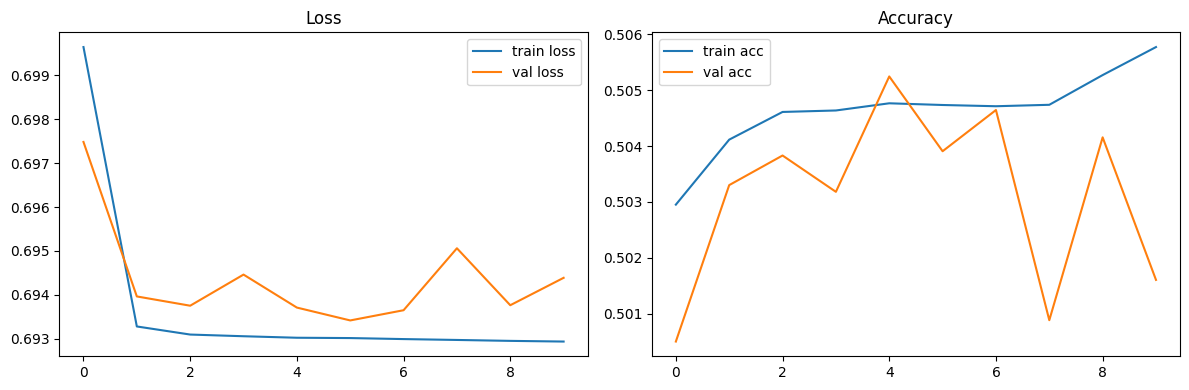

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], label='train loss')
plt.plot(training.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], label='train acc')
plt.plot(training.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
val_metrics = classifier.evaluate(val_ds, verbose=0)
test_metrics = classifier.evaluate(test_ds, verbose=0)
print(f"val_loss: {val_metrics[0]:.6f}, val_accuracy: {val_metrics[1]:.4f}")
print(f"test_loss: {test_metrics[0]:.6f}, test_accuracy: {test_metrics[1]:.4f}")

val_loss: 0.693711, val_accuracy: 0.5052
test_loss: 0.694274, test_accuracy: 0.5019


In [ ]:
# 💾 Save the trained model and asset mapping
print("💾 Saving trained classifier...")

classifier.save('results/classification_models/multiasset_classifier_final.keras')

# Save asset_to_id mapping
with open('results/classification_models/asset_to_id_multiasset.json', 'w') as f:
    json.dump(asset_to_id, f, indent=2)

print("✅ Classifier saved to:")
print("   - results/classification_models/multiasset_classifier_final.keras")
print("   - results/classification_models/asset_to_id_multiasset.json")

💾 Saving trained classifier...
✅ Classifier saved to:
   - results/classification_models/multiasset_classifier_final.keras
   - results/classification_models/asset_to_id_multiasset.json


## Classification Report

📊 Classification Report:
              precision    recall  f1-score   support

     BULLISH     0.5021    0.5217    0.5117    183027
     BEARISH     0.5017    0.4821    0.4917    182809

    accuracy                         0.5019    365836
   macro avg     0.5019    0.5019    0.5017    365836
weighted avg     0.5019    0.5019    0.5017    365836

              precision    recall  f1-score   support

     BULLISH     0.5021    0.5217    0.5117    183027
     BEARISH     0.5017    0.4821    0.4917    182809

    accuracy                         0.5019    365836
   macro avg     0.5019    0.5019    0.5017    365836
weighted avg     0.5019    0.5019    0.5017    365836



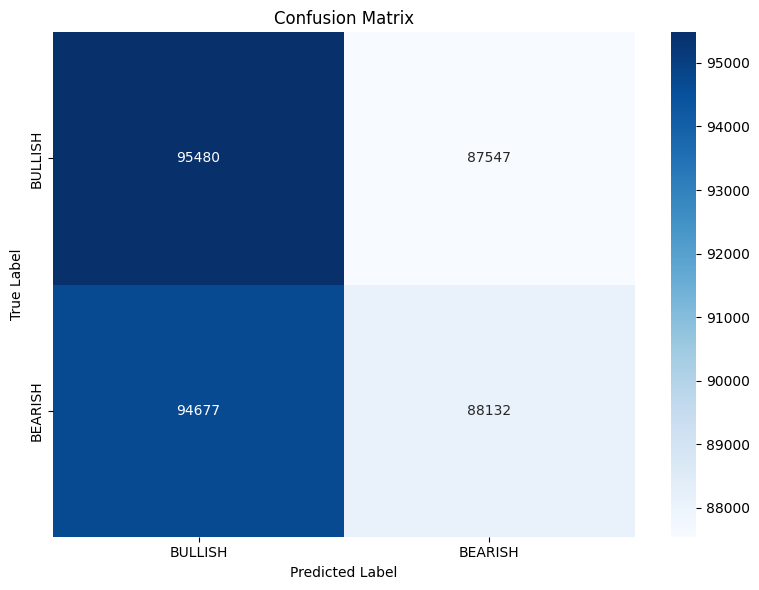


📈 Per-Class Accuracy:
  BULLISH: 52.17% (183027 samples)
  BEARISH: 48.21% (182809 samples)


In [ ]:
# Get predictions
y_pred_probs = classifier.predict(test_ds, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

target_arr = ['BULLISH', 'BEARISH']
# Classification report
print("📊 Classification Report:")
print(classification_report(y_te, y_pred,
                          target_names=target_arr,
                          digits=4))

# Confusion matrix
cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_arr,
            yticklabels=target_arr)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\n📈 Per-Class Accuracy:")
for i, label in enumerate(target_arr):
    mask = y_te == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).mean()
        print(f"  {label}: {acc:.2%} ({mask.sum()} samples)")


🎯 Prediction Confidence Analysis:
Mean confidence: 0.5186
Median confidence: 0.5118
Low confidence (<50%): 0 (0.0%)
High confidence (>80%): 0 (0.0%)


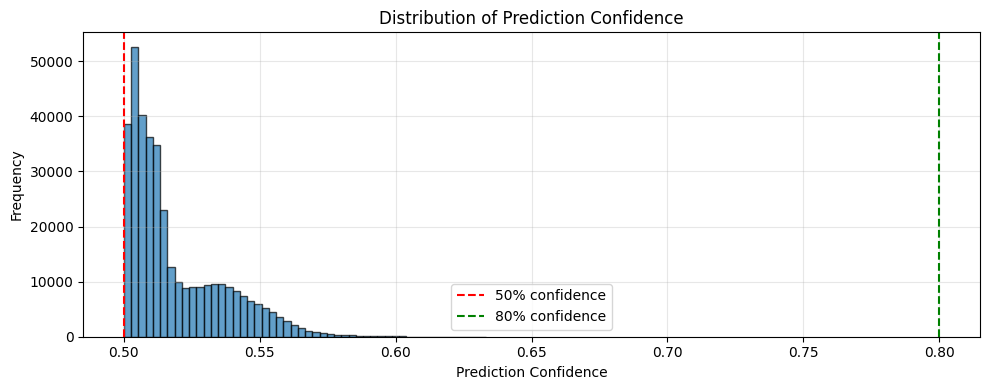

In [ ]:
# Confidence analysis
print("\n🎯 Prediction Confidence Analysis:")
max_probs = y_pred_probs.max(axis=1)
print(f"Mean confidence: {max_probs.mean():.4f}")
print(f"Median confidence: {np.median(max_probs):.4f}")
print(f"Low confidence (<50%): {(max_probs < 0.5).sum()} ({(max_probs < 0.5).mean()*100:.1f}%)")
print(f"High confidence (>80%): {(max_probs > 0.8).sum()} ({(max_probs > 0.8).mean()*100:.1f}%)")

plt.figure(figsize=(10, 4))
plt.hist(max_probs, bins=50, alpha=0.7, edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='50% confidence')
plt.axvline(0.8, color='green', linestyle='--', label='80% confidence')
plt.xlabel('Prediction Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Confidence')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()